<a href="https://colab.research.google.com/github/nehaiitr/Time-series-sales-prediction/blob/main/fb_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!7z x /content/drive/MyDrive/train.csv.7z
!7z x /content/drive/MyDrive/items.csv.7z
!7z x /content/drive/MyDrive/stores.csv.7z
!7z x /content/drive/MyDrive/transactions.csv.7z
!7z x /content/drive/MyDrive/holidays_events.csv.7z
!7z x /content/drive/MyDrive/oil.csv.7z

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('sparkpy').getOrCreate()

In [ ]:
sales= spark.read.csv('/content/train.csv')

In [ ]:
sales.show(20)

+---+----------+---------+--------+----------+-----------+
|_c0|       _c1|      _c2|     _c3|       _c4|        _c5|
+---+----------+---------+--------+----------+-----------+
| id|      date|store_nbr|item_nbr|unit_sales|onpromotion|
|  0|2013-01-01|       25|  103665|       7.0|       NULL|
|  1|2013-01-01|       25|  105574|       1.0|       NULL|
|  2|2013-01-01|       25|  105575|       2.0|       NULL|
|  3|2013-01-01|       25|  108079|       1.0|       NULL|
|  4|2013-01-01|       25|  108701|       1.0|       NULL|
|  5|2013-01-01|       25|  108786|       3.0|       NULL|
|  6|2013-01-01|       25|  108797|       1.0|       NULL|
|  7|2013-01-01|       25|  108952|       1.0|       NULL|
|  8|2013-01-01|       25|  111397|      13.0|       NULL|
|  9|2013-01-01|       25|  114790|       3.0|       NULL|
| 10|2013-01-01|       25|  114800|       1.0|       NULL|
| 11|2013-01-01|       25|  115267|       1.0|       NULL|
| 12|2013-01-01|       25|  115611|       1.0|       NUL

In [ ]:
sales.dtypes

[('_c0', 'string'),
 ('_c1', 'string'),
 ('_c2', 'string'),
 ('_c3', 'string'),
 ('_c4', 'string'),
 ('_c5', 'string')]

In [ ]:
from pyspark.sql.types import DateType
sales = sales.withColumn('_c0', sales['_c0'].cast("integer"))
sales = sales.withColumn('_c1', sales['_c1'].cast(DateType()))
sales = sales.withColumn('_c2', sales['_c2'].cast("integer"))
sales = sales.withColumn('_c3', sales['_c3'].cast("integer"))
sales = sales.withColumn('_c4', sales['_c4'].cast("integer"))
sales.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: date (nullable = true)
 |-- _c2: integer (nullable = true)
 |-- _c3: integer (nullable = true)
 |-- _c4: integer (nullable = true)
 |-- _c5: string (nullable = true)



In [ ]:
sales.count()

125497041

In [ ]:
sales= sales.drop('onpromotion')
sales =  sales.selectExpr(
    '_c0 AS id',
    '_c1 AS date',
    '_c2 AS store_id',
    '_c3 AS item_id',
    '_c4 AS unit_sales'
)

In [ ]:
sales= sales.where(sales.id>=0)

In [ ]:
items= spark.read.csv('/content/items.csv')
stores= spark.read.csv('/content/stores.csv')
oil= spark.read.csv('/content/oil.csv')
transactions= spark.read.csv('/content/transactions.csv')
holidays= spark.read.csv('/content/holidays_events.csv')

In [ ]:
items = items.withColumn('_c0', items['_c0'].cast("integer"))
items = items.withColumn('_c1', items['_c1'].cast("string"))
items = items.withColumn('_c2', items['_c2'].cast("integer"))
items = items.withColumn('_c3', items['_c3'].cast("integer"))

items = items.selectExpr(
    '_c0 AS item_id',
    '_c1 AS family',
    '_c2 AS class',
    '_c3 AS perishable',
)

items= items.where(items.item_id>=0)

items.printSchema()
items.show(5)

root
 |-- item_id: integer (nullable = true)
 |-- family: string (nullable = true)
 |-- class: integer (nullable = true)
 |-- perishable: integer (nullable = true)

+-------+------------+-----+----------+
|item_id|      family|class|perishable|
+-------+------------+-----+----------+
|  96995|   GROCERY I| 1093|         0|
|  99197|   GROCERY I| 1067|         0|
| 103501|    CLEANING| 3008|         0|
| 103520|   GROCERY I| 1028|         0|
| 103665|BREAD/BAKERY| 2712|         1|
+-------+------------+-----+----------+
only showing top 5 rows



In [ ]:
stores = stores.withColumn('_c0', stores['_c0'].cast("integer"))
stores = stores.withColumn('_c1', stores['_c1'].cast("string"))
stores = stores.withColumn('_c2', stores['_c2'].cast("string"))
stores = stores.withColumn('_c3', stores['_c3'].cast("string"))
stores = stores.withColumn('_c4', stores['_c4'].cast("integer"))

stores = stores.selectExpr(
    '_c0 AS store_id',
    '_c1 AS city',
    '_c2 AS state',
    '_c3 AS type',
    '_c4 AS cluster',
)

stores= stores.where(stores.store_id>=0)

stores.printSchema()
stores.show(5)

root
 |-- store_id: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cluster: integer (nullable = true)

+--------+-------------+--------------------+----+-------+
|store_id|         city|               state|type|cluster|
+--------+-------------+--------------------+----+-------+
|       1|        Quito|           Pichincha|   D|     13|
|       2|        Quito|           Pichincha|   D|     13|
|       3|        Quito|           Pichincha|   D|      8|
|       4|        Quito|           Pichincha|   D|      9|
|       5|Santo Domingo|Santo Domingo de ...|   D|      4|
+--------+-------------+--------------------+----+-------+
only showing top 5 rows



In [ ]:
oil = oil.withColumn('_c0', oil['_c0'].cast(DateType()))
oil = oil.withColumn('_c1', oil['_c1'].cast("integer"))

oil = oil.selectExpr(
    '_c0 AS date',
    '_c1 AS oil_price'
)

oil = oil.where(oil.date>='2013-01-01')

oil.printSchema()
oil.show(5)

root
 |-- date: date (nullable = true)
 |-- oil_price: integer (nullable = true)

+----------+---------+
|      date|oil_price|
+----------+---------+
|2013-01-01|     NULL|
|2013-01-02|       93|
|2013-01-03|       92|
|2013-01-04|       93|
|2013-01-07|       93|
+----------+---------+
only showing top 5 rows



In [ ]:
transactions = transactions.withColumn('_c0', transactions['_c0'].cast(DateType()))
transactions = transactions.withColumn('_c1', transactions['_c1'].cast("integer"))
transactions = transactions.withColumn('_c2', transactions['_c2'].cast("integer"))

transactions = transactions.selectExpr(
    '_c0 AS date',
    '_c1 AS store_id',
    '_c2 AS transactions'
)

transactions = transactions.where(transactions.date>='2013-01-01')

transactions.printSchema()
transactions.show(5)

root
 |-- date: date (nullable = true)
 |-- store_id: integer (nullable = true)
 |-- transactions: integer (nullable = true)

+----------+--------+------------+
|      date|store_id|transactions|
+----------+--------+------------+
|2013-01-01|      25|         770|
|2013-01-02|       1|        2111|
|2013-01-02|       2|        2358|
|2013-01-02|       3|        3487|
|2013-01-02|       4|        1922|
+----------+--------+------------+
only showing top 5 rows



In [ ]:
holidays= holidays.withColumn('_c0', holidays['_c0'].cast(DateType()))
holidays= holidays.withColumn('_c1', holidays['_c1'].cast("string"))
holidays= holidays.withColumn('_c2', holidays['_c2'].cast("string"))
holidays= holidays.withColumn('_c3', holidays['_c3'].cast("string"))
holidays= holidays.withColumn('_c4', holidays['_c4'].cast("string"))
holidays= holidays.withColumn('_c4', holidays['_c4'].cast("string"))

holidays= holidays.selectExpr(
    '_c0 AS date',
    '_c1 AS type',
    '_c2 AS locale',
    '_c3 AS locale_name',
    '_c4 AS description',
    '_c4 AS transferred',
)

holidays= holidays.where(holidays.date>='2012-03-02')

holidays.printSchema()
holidays.show(5)

root
 |-- date: date (nullable = true)
 |-- type: string (nullable = true)
 |-- locale: string (nullable = true)
 |-- locale_name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- transferred: string (nullable = true)

+----------+-------+--------+-----------+--------------------+--------------------+
|      date|   type|  locale|locale_name|         description|         transferred|
+----------+-------+--------+-----------+--------------------+--------------------+
|2012-03-02|Holiday|   Local|      Manta|  Fundacion de Manta|  Fundacion de Manta|
|2012-04-01|Holiday|Regional|   Cotopaxi|Provincializacion...|Provincializacion...|
|2012-04-12|Holiday|   Local|     Cuenca| Fundacion de Cuenca| Fundacion de Cuenca|
|2012-04-14|Holiday|   Local|   Libertad|Cantonizacion de ...|Cantonizacion de ...|
|2012-04-21|Holiday|   Local|   Riobamba|Cantonizacion de ...|Cantonizacion de ...|
+----------+-------+--------+-----------+--------------------+--------------------+
o

In [ ]:
sales.show(5)
items.show(5)
stores.show(5)

+---+----------+--------+-------+----------+
| id|      date|store_id|item_id|unit_sales|
+---+----------+--------+-------+----------+
|  0|2013-01-01|      25| 103665|         7|
|  1|2013-01-01|      25| 105574|         1|
|  2|2013-01-01|      25| 105575|         2|
|  3|2013-01-01|      25| 108079|         1|
|  4|2013-01-01|      25| 108701|         1|
+---+----------+--------+-------+----------+
only showing top 5 rows

+-------+------------+-----+----------+
|item_id|      family|class|perishable|
+-------+------------+-----+----------+
|  96995|   GROCERY I| 1093|         0|
|  99197|   GROCERY I| 1067|         0|
| 103501|    CLEANING| 3008|         0|
| 103520|   GROCERY I| 1028|         0|
| 103665|BREAD/BAKERY| 2712|         1|
+-------+------------+-----+----------+
only showing top 5 rows

+--------+-------------+--------------------+----+-------+
|store_id|         city|               state|type|cluster|
+--------+-------------+--------------------+----+-------+
|       

In [ ]:
sales.select('store_id').distinct().count()

54

In [ ]:
items.select('family').distinct().count()

33

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [ ]:
sale_by_day= sales.groupBy('date').sum('unit_sales').orderBy('date')
sale_by_day_df = sale_by_day.toPandas()

In [ ]:
sale_by_day_df

,date,sum(unit_sales)
0,2013-01-01,2488
1,2013-01-02,495195
2,2013-01-03,360522
3,2013-01-04,353495
4,2013-01-05,476381
...,...,...
1679,2017-08-11,822649
1680,2017-08-12,788957
1681,2017-08-13,861931
1682,2017-08-14,757232


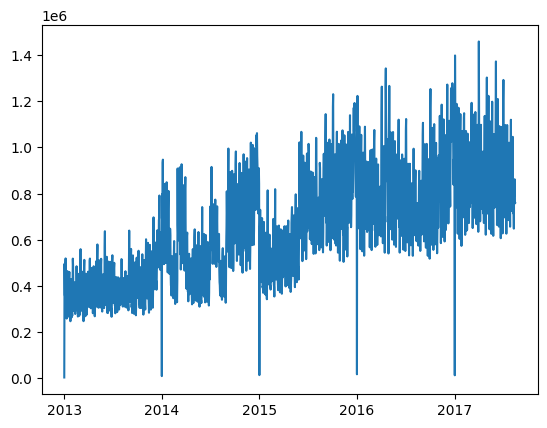

In [ ]:
plt.plot(sale_by_day_df['date'], sale_by_day_df['sum(unit_sales)'])

In [ ]:
sales_by_storeid= sales.groupBy('store_id').sum('unit_sales')
sales_by_storeid= sales_by_storeid.orderBy(['sum(unit_sales)'], ascending = [True])
sales_by_storeid_df= sales_by_storeid.toPandas()

In [ ]:
sales_by_storeid_df

,store_id,sum(unit_sales)
0,52,2685263
1,22,4067817
2,32,5923840
3,30,7339107
4,35,7636529
5,26,7675725
6,42,8887796
7,21,9216692
8,10,9577108
9,29,9679294


In [ ]:
sale_by_date_by_storeid= sales.groupBy('date','store_id').sum('unit_sales').orderBy('date')
sale_by_date_by_storeid_df= sale_by_date_by_storeid.toPandas()

In [ ]:
sale_by_date_by_storeid_df

,date,store_id,sum(unit_sales)
0,2013-01-01,25,2488
1,2013-01-02,28,5166
2,2013-01-02,9,15852
3,2013-01-02,25,5292
4,2013-01-02,38,9175
...,...,...,...
83601,2017-08-15,17,14069
83602,2017-08-15,26,3639
83603,2017-08-15,23,7281
83604,2017-08-15,15,7900


In [ ]:
oil_df= pd.read_csv('/content/oil.csv')
oil_df.set_index('date', inplace=True)
oil_df.index= pd.to_datetime(oil_df.index, infer_datetime_format=True)
start = oil_df.index[0].date()
end = oil_df.index[len(oil_df)-1].date()
new_dates = pd.date_range(start=start,end=end,freq='D')
oil_df = oil_df.reindex(new_dates)
oil_df = oil_df.rename_axis('date')
oil_df = (oil_df.ffill() + oil_df.bfill()) /2
oil_df = oil_df.bfill()

In [ ]:
oil_df

,dcoilwtico
date,
2013-01-01,93.140
2013-01-02,93.140
2013-01-03,92.970
2013-01-04,93.120
2013-01-05,93.160
...,...
2017-08-27,47.025
2017-08-28,46.400
2017-08-29,46.460


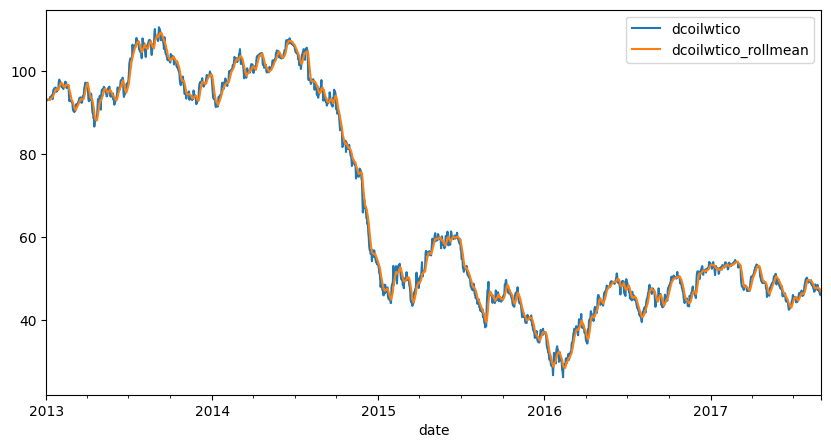

In [ ]:
oil_df.index.name = 'date'
oil_df['dcoilwtico_rollmean'] = oil_df['dcoilwtico'].rolling(window=7).mean()
oil_df.plot(y=['dcoilwtico', 'dcoilwtico_rollmean'], figsize=(10,5))
plt.show()

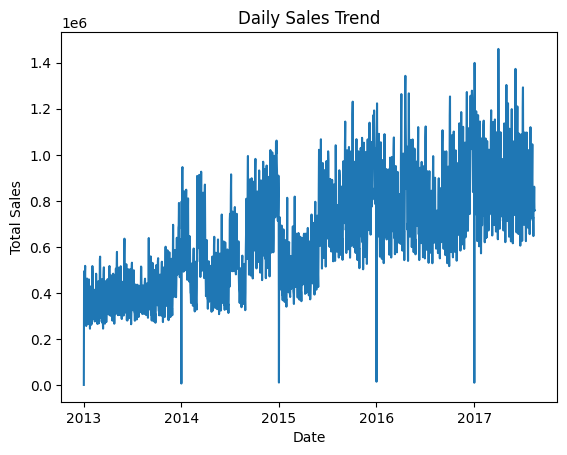

In [ ]:
# @title Daily Sales Trend

import matplotlib.pyplot as plt
plt.plot(sale_by_day_df['date'], sale_by_day_df['sum(unit_sales)'])
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Daily Sales Trend')
plt.show()


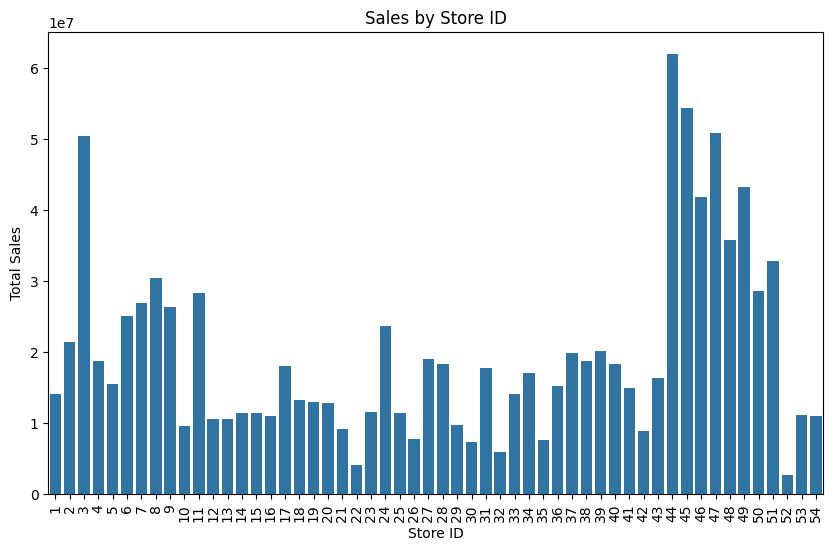

In [ ]:
# @title Sales by Store ID

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='store_id', y='sum(unit_sales)', data=sales_by_storeid_df)
plt.xlabel('Store ID')
plt.ylabel('Total Sales')
plt.title('Sales by Store ID')
plt.xticks(rotation=90)
plt.show()


In [ ]:
sales.join(items, sales.item_id==items.item_id, 'left').show(truncate=True)

+---+----------+--------+-------+----------+-------+-------------+-----+----------+
| id|      date|store_id|item_id|unit_sales|item_id|       family|class|perishable|
+---+----------+--------+-------+----------+-------+-------------+-----+----------+
|  0|2013-01-01|      25| 103665|         7| 103665| BREAD/BAKERY| 2712|         1|
|  1|2013-01-01|      25| 105574|         1| 105574|    GROCERY I| 1045|         0|
|  2|2013-01-01|      25| 105575|         2| 105575|    GROCERY I| 1045|         0|
|  3|2013-01-01|      25| 108079|         1| 108079|    GROCERY I| 1030|         0|
|  4|2013-01-01|      25| 108701|         1| 108701|         DELI| 2644|         1|
|  5|2013-01-01|      25| 108786|         3| 108786|     CLEANING| 3044|         0|
|  6|2013-01-01|      25| 108797|         1| 108797|    GROCERY I| 1004|         0|
|  7|2013-01-01|      25| 108952|         1| 108952|     CLEANING| 3024|         0|
|  8|2013-01-01|      25| 111397|        13| 111397|    GROCERY I| 1072|    

In [ ]:
sales_by_family = sales.join(items, sales.item_id==items.item_id, 'left').groupBy('date','family').sum('unit_sales').orderBy(['family','date'])
sales_by_family_df= sales_by_family.toPandas()

In [ ]:
sales_by_family_df

,date,family,sum(unit_sales)
0,2013-01-02,AUTOMOTIVE,255
1,2013-01-03,AUTOMOTIVE,161
2,2013-01-04,AUTOMOTIVE,169
3,2013-01-05,AUTOMOTIVE,342
4,2013-01-06,AUTOMOTIVE,360
...,...,...,...
47498,2017-08-11,SEAFOOD,1250
47499,2017-08-12,SEAFOOD,1001
47500,2017-08-13,SEAFOOD,1094
47501,2017-08-14,SEAFOOD,944


In [ ]:
sales_by_family_df_pivoted= sales_by_family_df.pivot(index='date',columns='family', values='sum(unit_sales)')

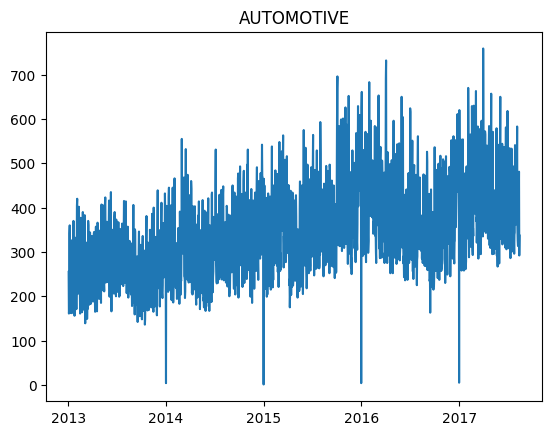

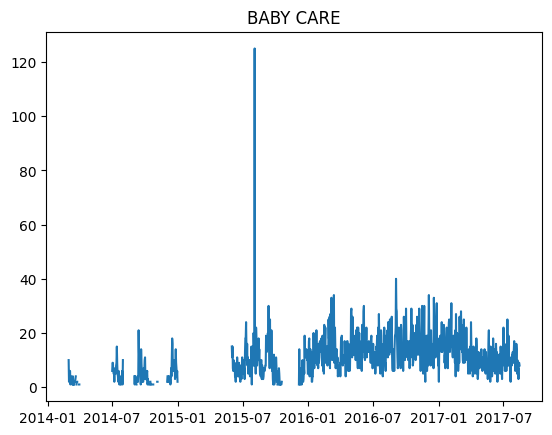

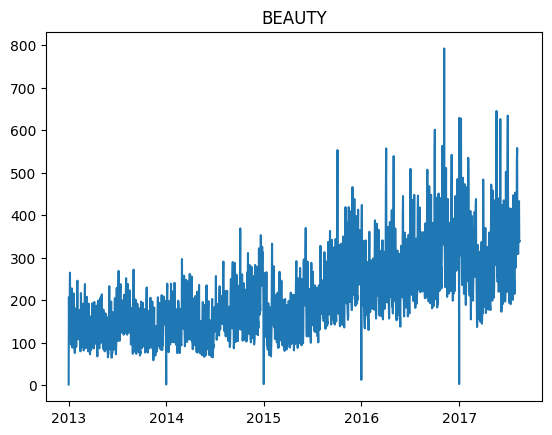

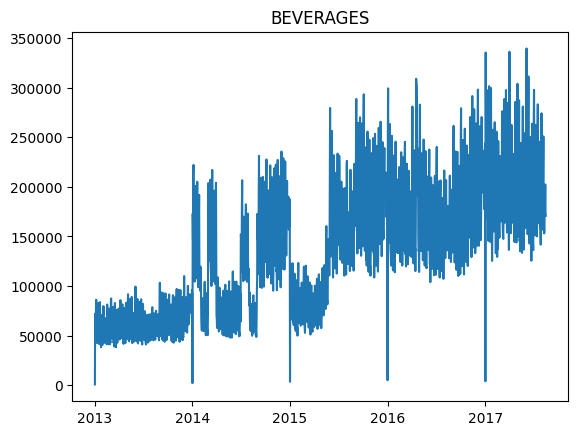

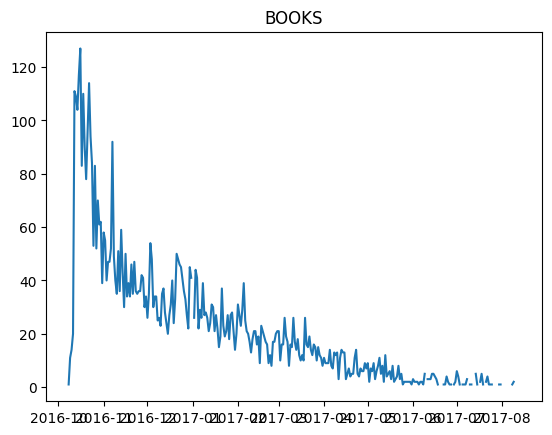

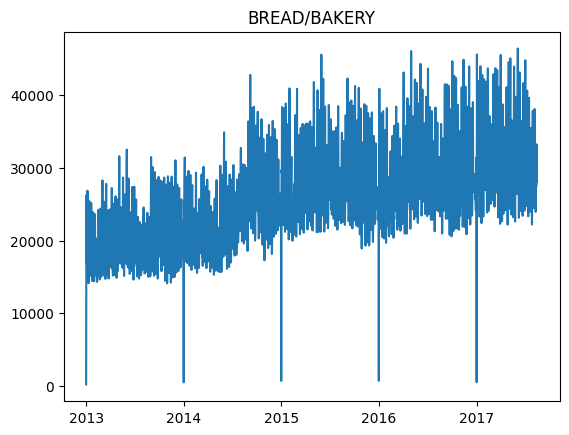

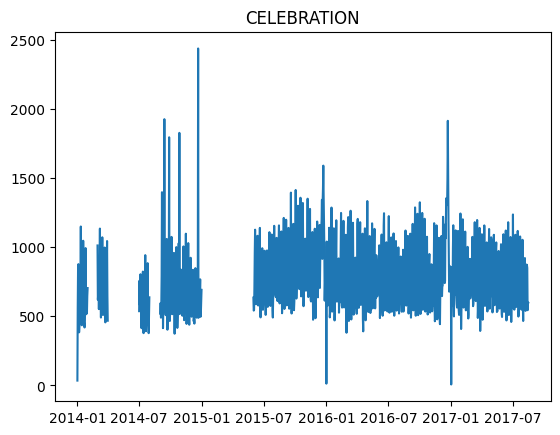

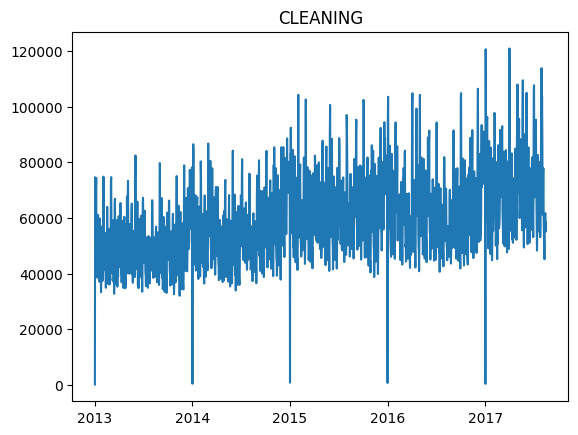

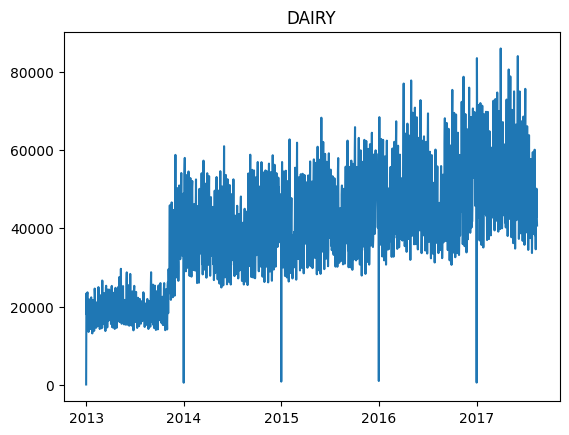

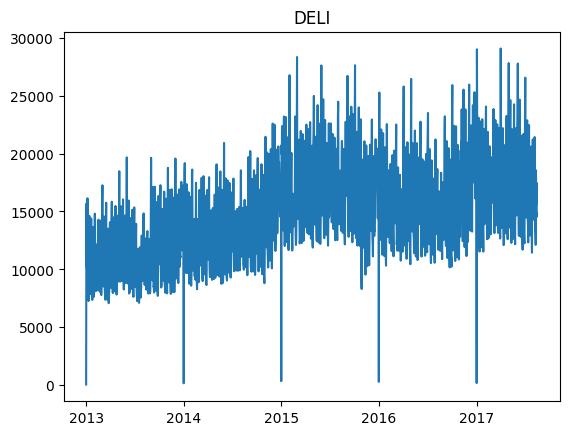

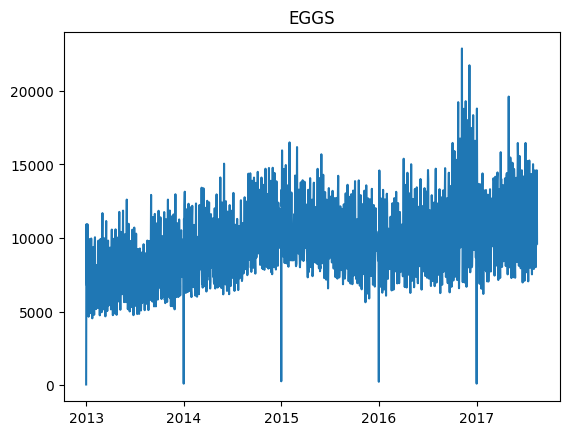

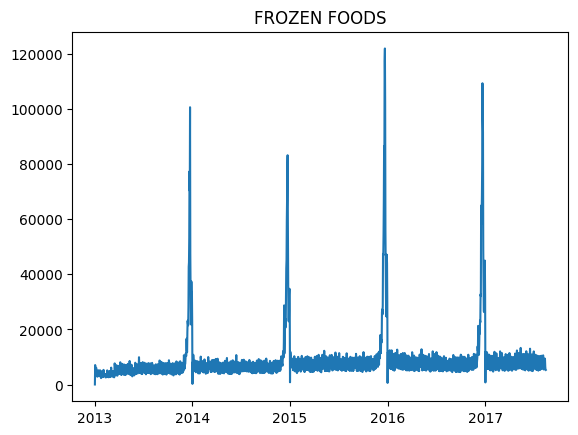

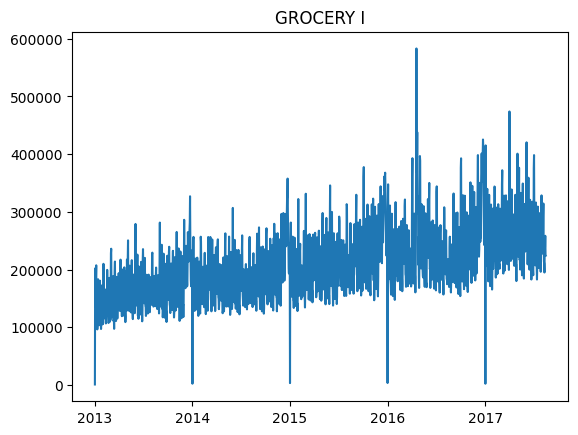

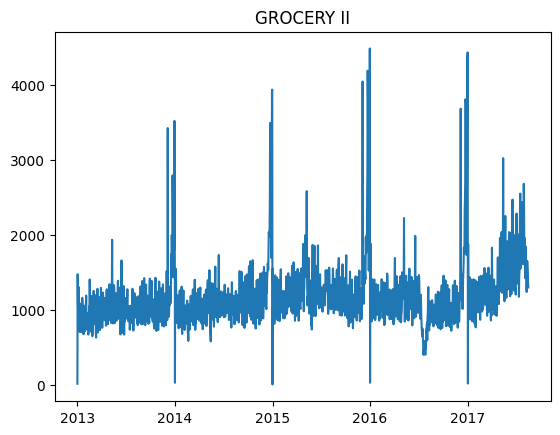

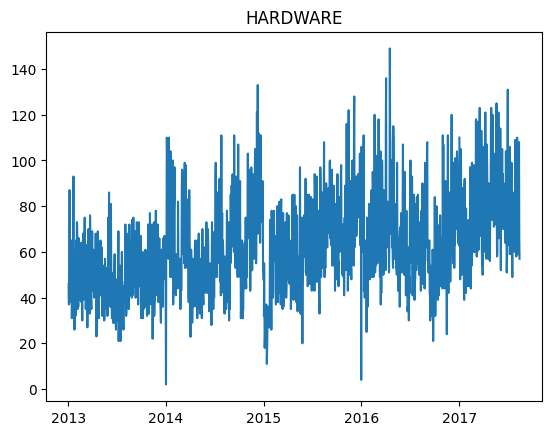

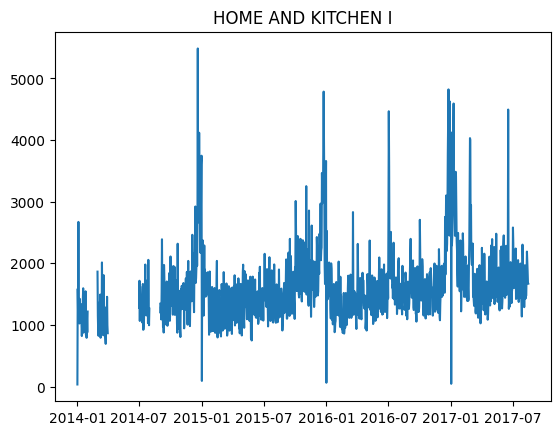

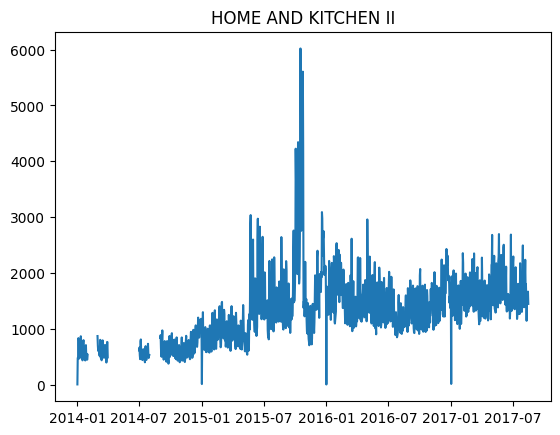

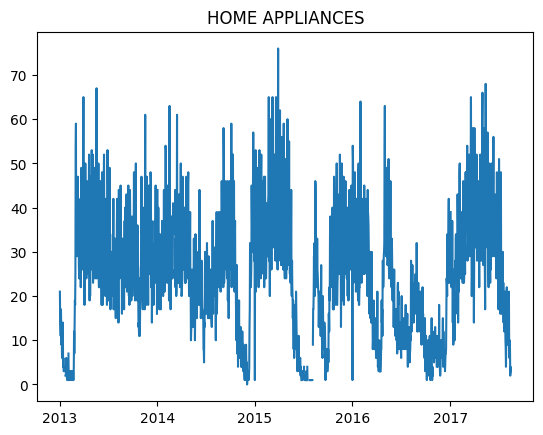

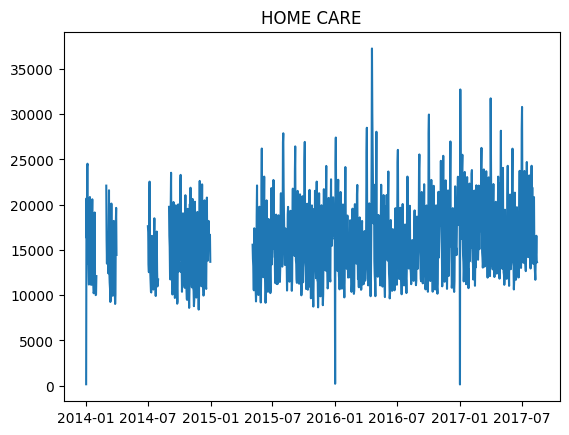

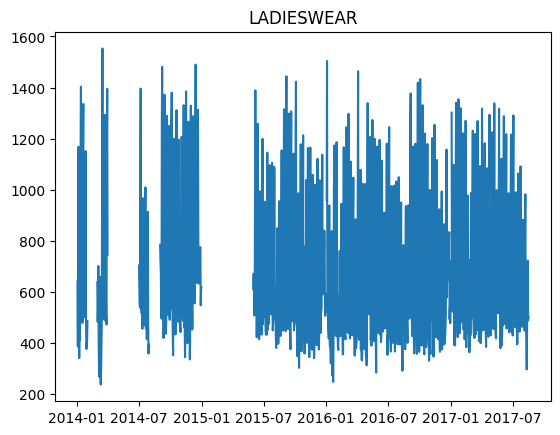

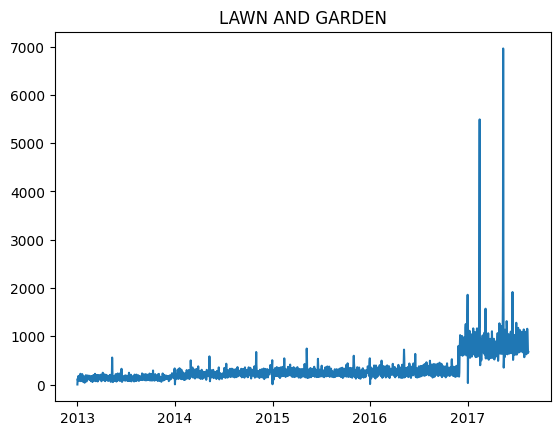

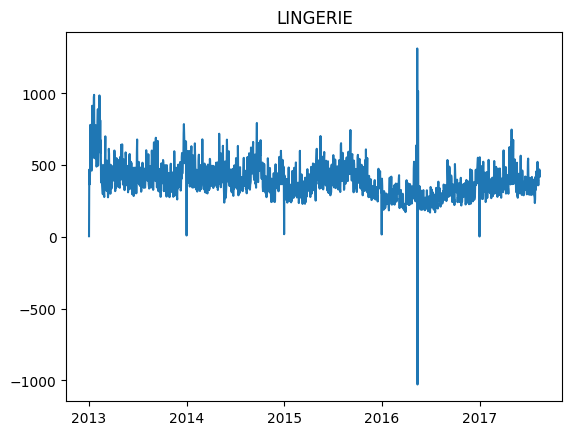

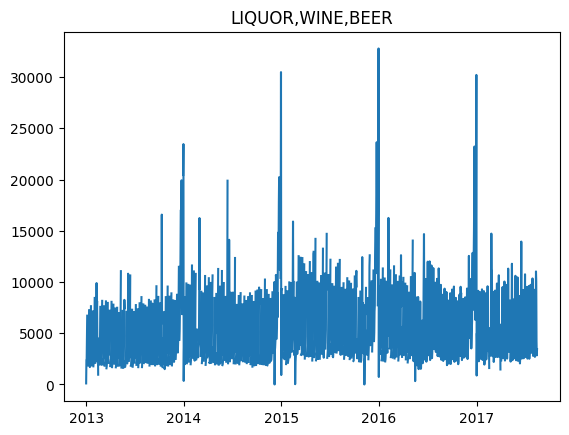

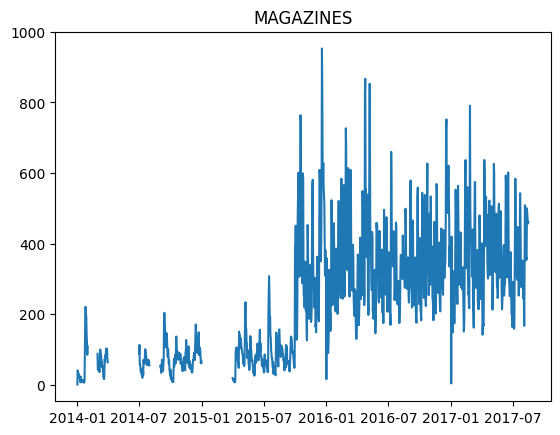

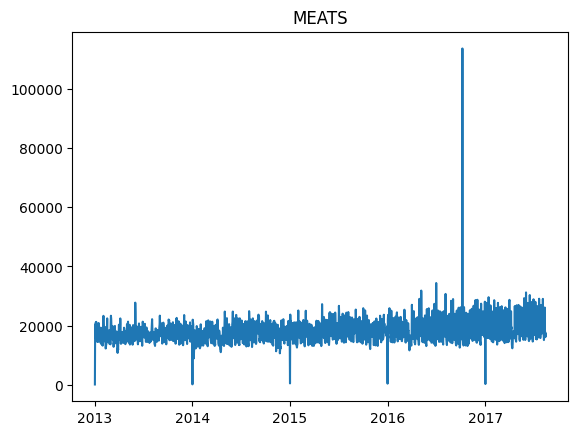

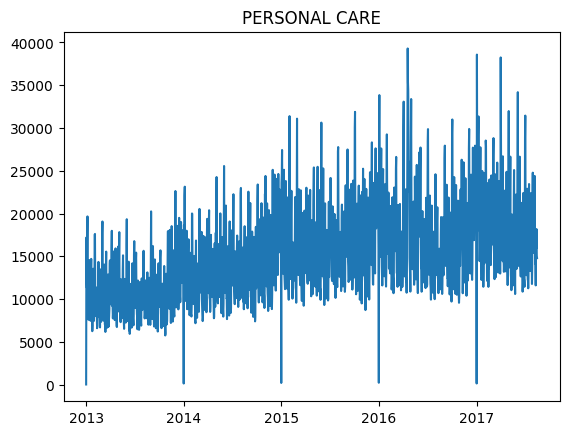

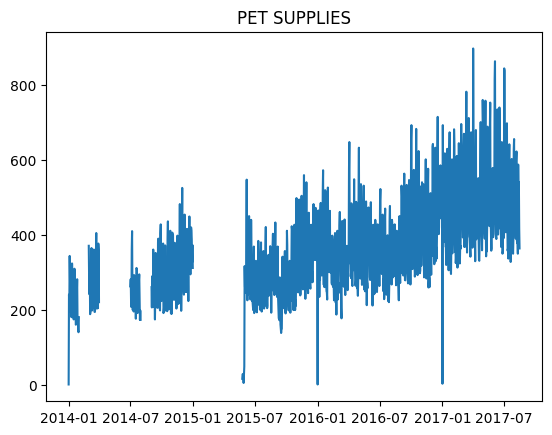

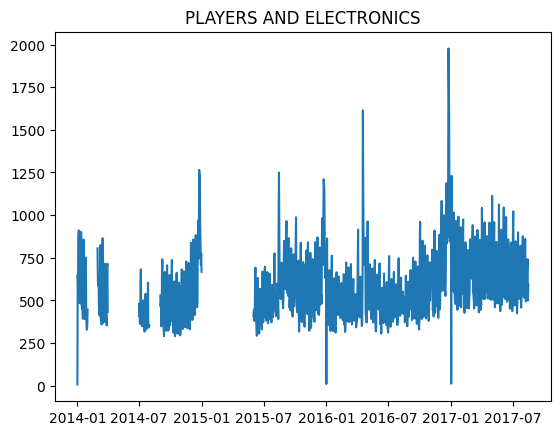

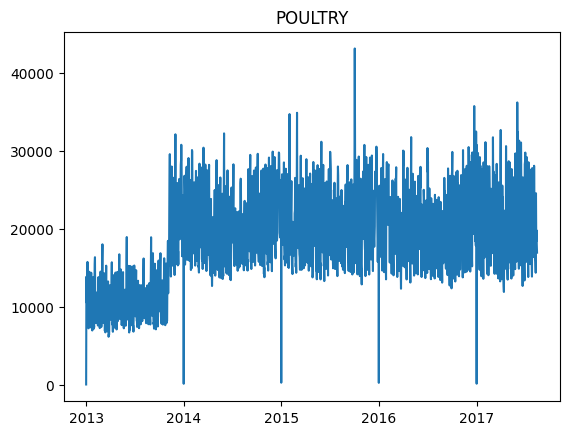

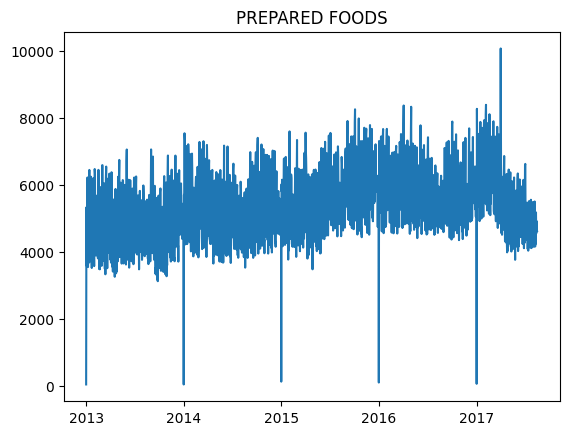

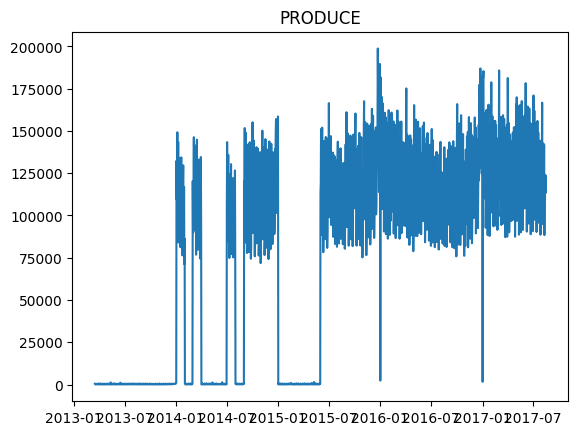

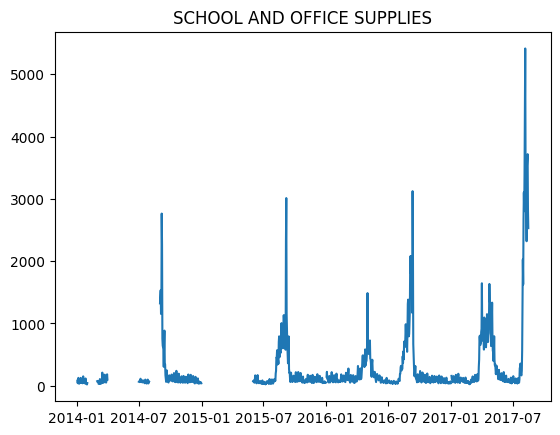

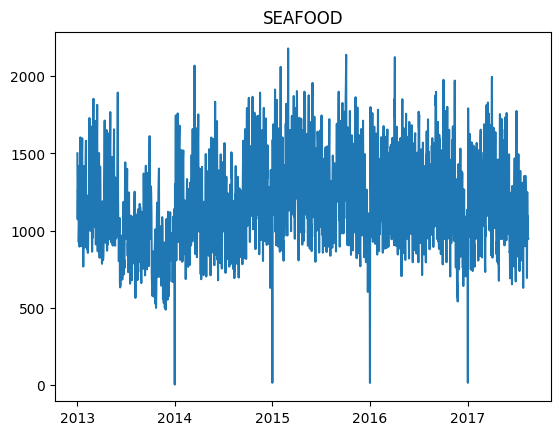

In [ ]:
for column in sales_by_family_df_pivoted.columns:
  plt.plot(sales_by_family_df_pivoted[column])
  plt.title(column)
  plt.show()

In [ ]:
df_automotive = sales_by_family_df_pivoted[['AUTOMOTIVE']].reset_index()
df_automotive.head()

family,date,AUTOMOTIVE
0,2013-01-01,NaN
1,2013-01-02,255.0
2,2013-01-03,161.0
3,2013-01-04,169.0
4,2013-01-05,342.0


In [ ]:
df_automotive= df_automotive.bfill()
df_automotive

family,date,AUTOMOTIVE
0,2013-01-01,255.0
1,2013-01-02,255.0
2,2013-01-03,161.0
3,2013-01-04,169.0
4,2013-01-05,342.0
...,...,...
1679,2017-08-11,441.0
1680,2017-08-12,403.0
1681,2017-08-13,481.0
1682,2017-08-14,292.0


In [ ]:
holidays= pd.read_csv('/content/holidays_events.csv')
holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [ ]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

In [ ]:
df_automotive = df_automotive.rename(columns={'date': 'ds', 'AUTOMOTIVE': 'y'})
df_automotive[['y']] = df_automotive[['y']].apply(pd.to_numeric)

df_automotive['ds'] = pd.to_datetime(df_automotive['ds'])

train_set = df_automotive

m = Prophet()

m.fit(train_set)

prediction_days= 30

future_df = m.make_future_dataframe(periods= prediction_days)
prophet_train = m.predict(future_df)

predicted_df = prophet_train[['ds','yhat']]

In [ ]:
predicted_df = predicted_df.merge(df_automotive)

In [ ]:
predicted_df

,ds,yhat,y
0,2013-01-01,229.892189,255.0
1,2013-01-02,222.790545,255.0
2,2013-01-03,204.548622,161.0
3,2013-01-04,217.697027,169.0
4,2013-01-05,357.798032,342.0
...,...,...,...
1679,2017-08-11,358.676974,441.0
1680,2017-08-12,503.403441,403.0
1681,2017-08-13,524.717302,481.0
1682,2017-08-14,364.300643,292.0


In [ ]:
def mape(actual, pred):                                   # Returns %error
  actual, pred = np.array(actual), np.array(pred)
  return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
mape(predicted_df['y'], predicted_df['yhat'])

45.834782212727475

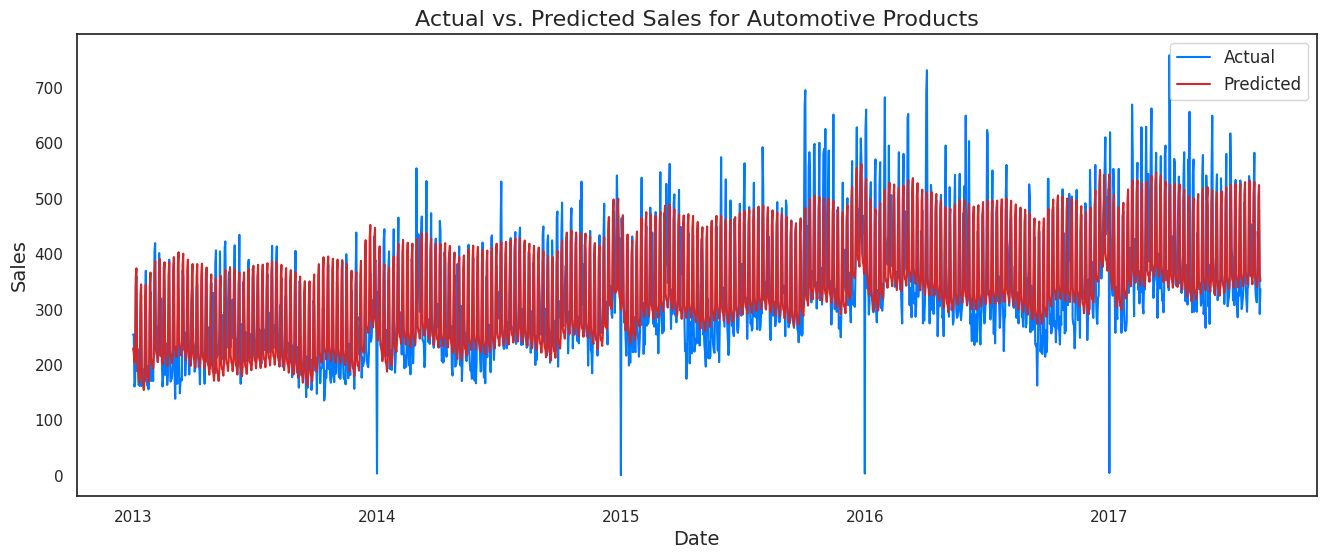

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))

sns.lineplot(data=predicted_df, x="ds", y="y", label="Actual", color="#007bff")
sns.lineplot(data=predicted_df, x="ds", y="yhat", label="Predicted", color="#d62728")

plt.title("Actual vs. Predicted Sales for Automotive Products", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Sales", fontsize=14)

plt.legend(fontsize=12)

plt.show()

In [ ]:
# @title Using cross validation to find best parameters
m = Prophet()
m.fit(train_set)
predicted_df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days')

In [ ]:
performance_metrics(predicted_df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,3383.942189,58.171661,42.056812,2.667377,0.092805,0.130962,0.816794
1,4 days,4223.517228,64.988593,46.830460,2.675704,0.105404,0.141124,0.780187
2,5 days,4694.874072,68.519151,50.969510,2.631773,0.111289,0.153918,0.726752
3,6 days,4122.939601,64.210121,50.777241,0.145380,0.112204,0.145729,0.688931
4,7 days,3991.493639,63.178269,50.801690,0.149006,0.140219,0.146776,0.648855
5,8 days,6381.233394,79.882623,57.761452,0.899262,0.147813,0.168614,0.595420
6,9 days,8451.503685,91.932060,65.078145,0.910557,0.144306,0.183527,0.572519
7,10 days,8468.575316,92.024862,65.044684,0.894566,0.142642,0.185012,0.576509
8,11 days,6569.209632,81.050661,57.949560,0.160072,0.119865,0.162073,0.644171
9,12 days,5140.944321,71.700379,53.367688,0.156398,0.112304,0.153454,0.651631


Figure(1000x600)


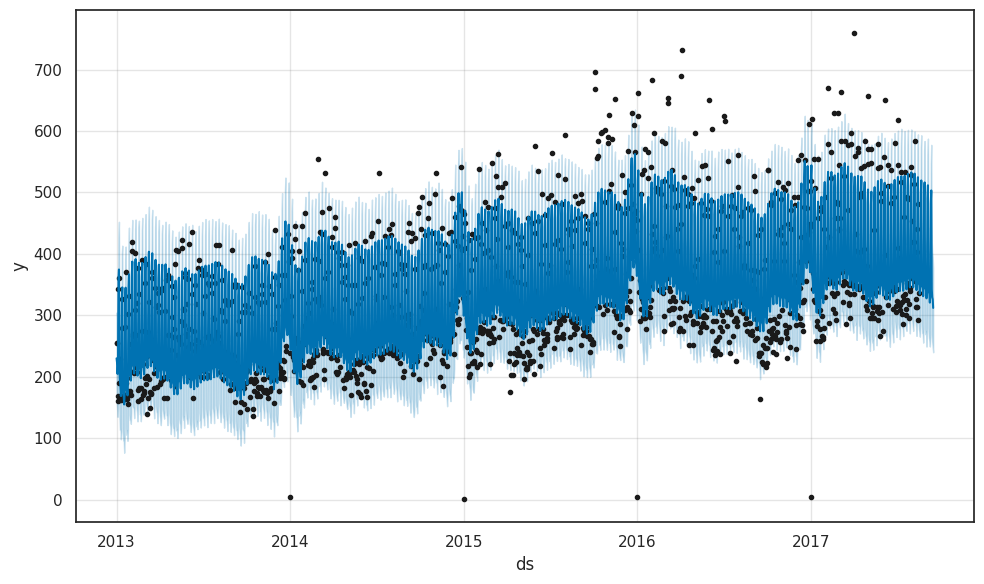

In [ ]:
print(m.plot(prophet_train))

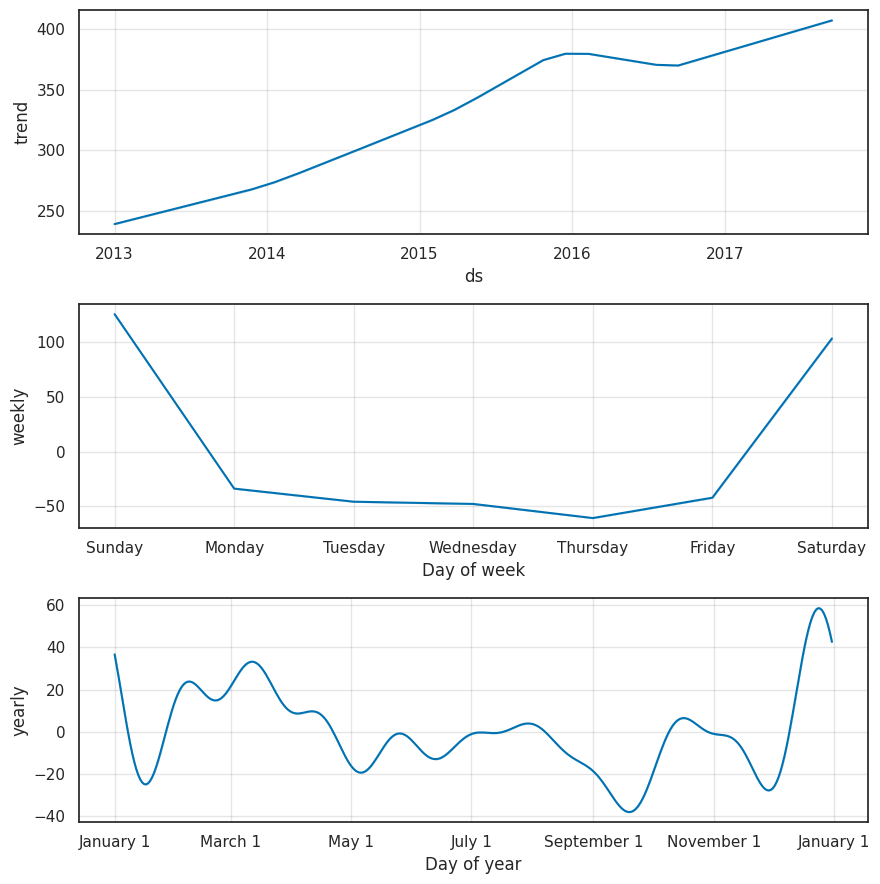

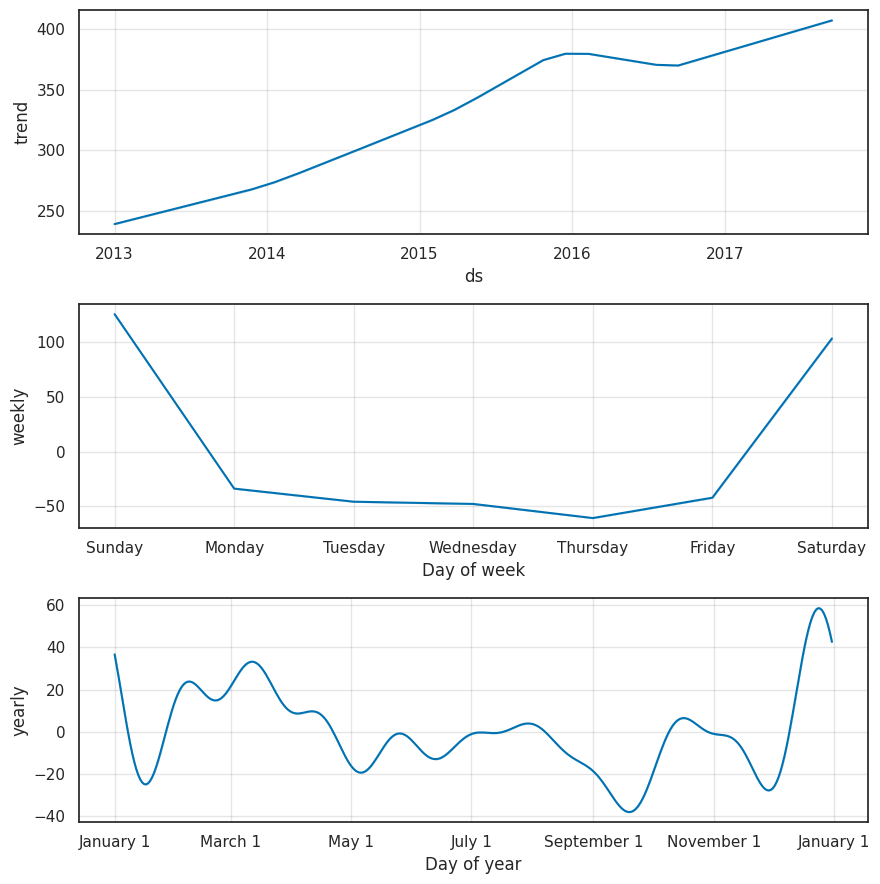

In [ ]:
m.plot_components(prophet_train)